In [ ]:
# Import
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Carica dataset
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_df = pd.DataFrame(ds["train"])
val_df = pd.DataFrame(ds["validation"])

# Preprocessing
train_df = train_df.dropna(subset=["name", "description", "label"])
val_df = val_df.dropna(subset=["name", "description", "label"])
train_df["text"] = train_df["name"] + " " + train_df["description"]
val_df["text"] = val_df["name"] + " " + val_df["description"]

# Encoding delle label
label_enc = LabelEncoder()
train_df["label_encoded"] = label_enc.fit_transform(train_df["label"])
val_df["label_encoded"] = label_enc.transform(val_df["label"])

# Conversione in Dataset HuggingFace
train_dataset = Dataset.from_pandas(train_df[["text", "label_encoded"]].rename(columns={"label_encoded": "label"}))
val_dataset = Dataset.from_pandas(val_df[["text", "label_encoded"]].rename(columns={"label_encoded": "label"}))


# Tokenizer e modello
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenizzazione
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

# Funzione di calcolo delle metriche, inclusa la confusion matrix
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    
    # Calcola la confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Visualizzazione della confusion matrix con Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calcola le metriche di classificazione
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }

# Parametri di training
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Allenamento
trainer.train()
trainer.save_model("lm_cultural_classifier")

# Funzione predizione
def predict(df, output_path="predictions.csv"):
    df = df.dropna(subset=["item_name", "description"])
    df["text"] = df["item_name"] + " " + df["description"]
    
    with torch.no_grad():
        inputs = tokenizer(df["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
        outputs = model(**inputs)
        preds = outputs.logits.argmax(axis=1).detach().cpu().numpy()
    
    df["classification"] = label_enc.inverse_transform(preds)
    df[["wikidata_link", "item_name", "description", "type", "category", "classification"]].to_csv(output_path, index=False)

# Esegui predizione (decommenta per test)
predict(val_df, "dev_predictions.csv")


Generating validation split: 100%|██████████| 300/300 [00:00<00:00, 77200.52 examples/s]
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 300/300 [00:00<00:00, 9195.88 examples/s]


Step,Training Loss
10,1.062900
20,0.978500
30,0.875300
40,0.824000
50,0.803800
60,0.754000
70,0.694200
80,0.683300
90,0.634500
100,0.592700


TypeError: argument of type 'method' is not iterable

In [ ]:
def predict(df, output_path):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        inputs = tokenizer(df["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
        # Sposta tutto su GPU o CPU coerentemente
        inputs = {key: val.to(device) for key, val in inputs.items()}

        outputs = model(**inputs)
        preds = outputs.logits.argmax(axis=1).detach().cpu().numpy()

    df["classification"] = label_enc.inverse_transform(preds)
    df[[ "name", "description", "type", "category", "label"]].to_csv(output_path, index=False)

# Esegui predizione (decommenta per test)
predict(val_df, "dev_predictions.csv")


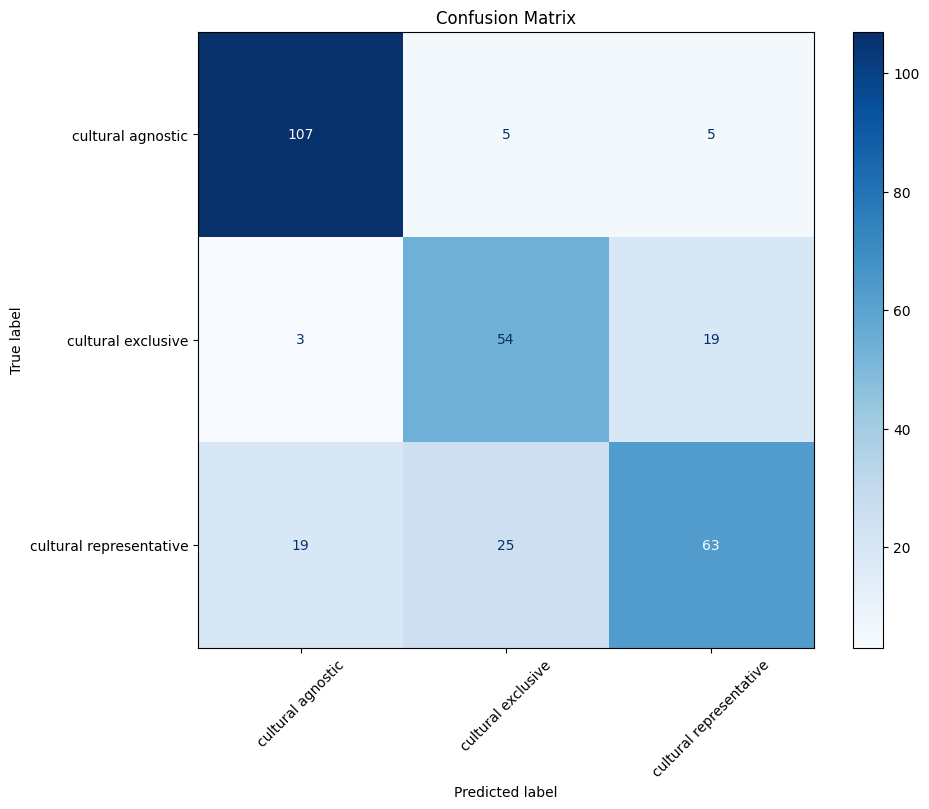

                         precision    recall  f1-score   support

      cultural agnostic       0.83      0.91      0.87       117
     cultural exclusive       0.64      0.71      0.68        76
cultural representative       0.72      0.59      0.65       107

               accuracy                           0.75       300
              macro avg       0.73      0.74      0.73       300
           weighted avg       0.74      0.75      0.74       300



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

with torch.no_grad():
    inputs = tokenizer(val_df["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    preds = outputs.logits.argmax(dim=1).detach().cpu().numpy()
    val_df["classification"] = label_enc.inverse_transform(preds)


def plot_confusion_matrix(df):
    y_true = df["label"]
    y_pred = df["classification"]

    # Crea la confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=label_enc.classes_)
    
    # Visualizza la confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_enc.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Dopo aver eseguito la predizione
val_df["classification"] = label_enc.inverse_transform(
    model(
        **{k: v.to(device) for k, v in tokenizer(val_df["text"].tolist(), padding=True, truncation=True, return_tensors="pt").items()}
    ).logits.argmax(dim=1).detach().cpu().numpy()
)
plot_confusion_matrix(val_df)
from sklearn.metrics import classification_report

print(classification_report(val_df["label"], val_df["classification"], target_names=label_enc.classes_))

